In [1]:
# Make sure to install the requirements with pip install -r requirements.txt
import os
os.chdir('..')
from matplotlib import pyplot as plt
import numpy as np
import torch
from lib.model import get_model_and_optim
from lib.data import prepare_nuclear_data
from lib.utils import  PlottingContext, IO, get_rms
from sklearn.decomposition import PCA
import seaborn as sns
sns.set_style('white')
sns.set_context('paper')
import glob
from collections import defaultdict

In [2]:
import re
# locations = glob.glob('/checkpoint/nolte/nuclr/long-runs/*')
locations = glob.glob('/checkpoint/nolte/NuCLR-MechInterp-results/*')
print(locations)
# get train fracs for full
# all_re = re.compile(".*/epochs-50000-binding100\+.*-seed(\d)-dataseed\d-trainfrac(\d+\.\d+).*ge8")
all_re = re.compile("epochs-100000-binding100\+.*-seed(\d)-dataseed\d-trainfrac(\d+\.\d+)-nuclei_ge8-hiddendim1024-LR0.0003")
binding_re = re.compile(".*/long_run-binding100-seed0-trainfrac(\d+\.\d+)")
binding_semf_re = re.compile(".*/long_run-binding_semf100-seed0-trainfrac(\d+\.\d+)")
# get train fracs for partial
all_trainfracs = {}
for loc in locations:
    match = all_re.search(loc)
    if match is not None:
      # if float(match.group(2)) > 0.7: continue
      all_trainfracs[(int(match.group(1)), float(match.group(2)))] = loc
print(len(all_trainfracs))

['/checkpoint/nolte/NuCLR-MechInterp-results/long_run-binding_semf100-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-binding100-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-z1-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-n1-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-radius0.02-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-qa200-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-qbm200-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-qbm_n200-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-qec200-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-sn200-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-sp200-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-binding100+z1+n1+radius0.02+qa200+qbm200+qbm_n200+qec200+sn200+sp200-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/trainfrac_0.8', '/checkpoint/nolte/NuCLR-MechInterp-results/trainfrac

In [3]:
def get_all_checkpoints_from(dir):
    checkpoints = {}
    for ckpt in os.listdir(dir):
        if ckpt.endswith('.pt') and "-" in ckpt:
            epoch = int(ckpt.split('-')[1].split('.')[0])
            if epoch % 5000 == 0: # WARNING
                checkpoints[epoch] = ckpt
    return checkpoints

def get_preds(X, model, batch=10000):
    preds = torch.zeros(X.shape[0], 1).to(X.device)
    with torch.no_grad():
        for i in range(0, X.shape[0], batch):
            preds_ = model(X[i:i+batch])
            # preds_ = torch.gather(preds_, 1, X[i:i+batch, [2]])
            preds[i:i+batch] = preds_
    return preds

def fix_val_mask_to_include_only_used_elements(data):
    non_nan_targets = ~torch.isnan(data.y.view(-1))
    X_train = data.X[data.train_mask & non_nan_targets]
    Z_train = X_train[:, 0].unique() 
    N_train = X_train[:, 1].unique()
    return data.val_mask & torch.isin(data.X[:, 0], Z_train) & torch.isin(data.X[:, 1], N_train)


def get_rms(model, data, split="all"):
    #filter out nans
    non_nan_targets = ~torch.isnan(data.y.view(-1))

    if split == "all":
        mask = torch.ones_like(data.y.view(-1), dtype=torch.bool)
    elif split == "train":
        mask = data.train_mask
    elif split == "val":
        mask = fix_val_mask_to_include_only_used_elements(data)
        print(mask.float().mean().item(), end="\r")

    X = data.X[non_nan_targets & mask]
    y = data.y[non_nan_targets & mask]
    

    preds = get_preds(X, model)
    rms = {}
    for i, task_name in enumerate(data.output_map):
        task_mask = X[:, 2] == i
        rms[task_name] = torch.sqrt(torch.mean((preds[task_mask] - y[task_mask])**2)).item()
    return rms

In [4]:
perfs = {}
import tqdm
for frac, location in tqdm.tqdm(all_trainfracs.items()):
  args = IO.load_args(f"{location}/args.yaml")
  args.DEV = "cuda:1"
  data = prepare_nuclear_data(args)
  model = get_model_and_optim(data, args)[0]
  model.load_state_dict(torch.load(f"{location}/ckpts/model.pt"))

  checkpoints = get_all_checkpoints_from(location + '/ckpts')

  task_rms_values = {}
  for epoch, ckpt in checkpoints.items():
      model.load_state_dict(torch.load(f"{location}/ckpts/{ckpt}"))
      task_rms_values[epoch] = get_rms(model, data, "val")["n"]
  perfs[frac] = task_rms_values


  0%|          | 0/27 [00:00<?, ?it/s]

  4%|▎         | 1/27 [00:03<01:38,  3.77s/it]

  7%|▋         | 2/27 [00:05<01:04,  2.59s/it]

 11%|█         | 3/27 [00:07<00:53,  2.22s/it]

 15%|█▍        | 4/27 [00:09<00:48,  2.09s/it]

 19%|█▊        | 5/27 [00:10<00:43,  1.98s/it]

 22%|██▏       | 6/27 [00:12<00:40,  1.94s/it]

 26%|██▌       | 7/27 [00:14<00:36,  1.83s/it]

 30%|██▉       | 8/27 [00:16<00:33,  1.77s/it]

 33%|███▎      | 9/27 [00:17<00:31,  1.77s/it]

 37%|███▋      | 10/27 [00:19<00:28,  1.70s/it]

 41%|████      | 11/27 [00:21<00:27,  1.70s/it]

 44%|████▍     | 12/27 [00:22<00:24,  1.65s/it]

 48%|████▊     | 13/27 [00:24<00:22,  1.60s/it]

 52%|█████▏    | 14/27 [00:25<00:21,  1.62s/it]

 56%|█████▌    | 15/27 [00:27<00:19,  1.60s/it]

 59%|█████▉    | 16/27 [00:28<00:17,  1.56s/it]

 63%|██████▎   | 17/27 [00:30<00:15,  1.57s/it]

 67%|██████▋   | 18/27 [00:31<00:13,  1.53s/it]

 70%|███████   | 19/27 [00:33<00:11,  1.50s/it]

 74%|███████▍  | 20/27 [00:34<00:10,  1.51s/it]

 78%|███████▊  | 21/27 [00:36<00:08,  1.48s/it]

 81%|████████▏ | 22/27 [00:37<00:07,  1.47s/it]

 85%|████████▌ | 23/27 [00:39<00:05,  1.43s/it]

 89%|████████▉ | 24/27 [00:40<00:04,  1.40s/it]

 93%|█████████▎| 25/27 [00:41<00:02,  1.38s/it]

 96%|█████████▋| 26/27 [00:42<00:01,  1.32s/it]

100%|██████████| 27/27 [00:44<00:00,  1.63s/it]

In [5]:
last_epoch = list(checkpoints.keys())[-1]
print(last_epoch)

NameError: name 'checkpoints' is not defined

In [30]:
# with RMS calculated only on the good elements, this is not valid anymore
def train_mask_has_all_elements(data):
  all_Z = data.X[:,0].unique()
  all_N = data.X[:,1].unique()
  train_X = data.X[data.train_mask]
  train_Z = train_X[:,0].unique()
  train_N = train_X[:,1].unique()
  for z in all_Z:
    if z not in train_Z:
      return False 
  for n in all_N:
    if n not in train_N:
      return False
  return True

keys = all_trainfracs.keys()
for key in keys:
  # model.load_state_dict(torch.load(f"{all_trainfracs[key]}/ckpts/model.pt"))
  args = IO.load_args(f"{all_trainfracs[key]}/args.yaml")
  args.DEV = "cpu"
  data = prepare_nuclear_data(args)
  print(key, train_mask_has_all_elements(data), min(perfs[key].values()))

(0, 0.1) False 2.1154000759124756
(1, 0.1) False 1.5554715394973755
(2, 0.1) False 1.082643747329712
(0, 0.2) False 0.7234092950820923
(1, 0.2) False 0.2789391875267029
(2, 0.2) False 0.6271085739135742
(0, 0.3) False 0.31070396304130554
(1, 0.3) False 0.1999780237674713
(2, 0.3) False 0.4438713788986206
(0, 0.4) False 0.1746186465024948
(1, 0.4) False 0.12024761736392975
(2, 0.4) False 0.16164208948612213
(0, 0.5) False 0.11852146685123444
(1, 0.5) False 0.09279416501522064
(2, 0.5) False 0.17415545880794525
(0, 0.6) False 0.10972326993942261
(1, 0.6) False 0.08968072384595871
(2, 0.6) False 0.10107572376728058
(0, 0.7) False 0.10274548828601837
(1, 0.7) False 0.08635850250720978
(2, 0.7) False 0.08479154109954834
(0, 0.8) False 0.08567558974027634
(1, 0.8) False 0.07288294285535812
(2, 0.8) True 0.08373746275901794
(0, 0.9) True 0.08362222462892532
(1, 0.9) False 0.06625404208898544
(2, 0.9) True 0.07957500964403152


In [31]:
perfs_with_unc = defaultdict(list)
for train_frac in set([x[1] for x in perfs.keys()]):
  for seed in set([x[0] for x in perfs.keys()]):
    # if seed != 1: continue
    perfs_with_unc[train_frac].append(perfs[(seed, train_frac)][last_epoch])
perfs_with_unc = {k: (np.mean(v), np.std(v)) for k,v in perfs_with_unc.items()}
perfs_with_unc

{0.1: (1.6437435150146484, 0.3548990805601073),
 0.4: (0.1655430148045222, 0.03409252615689802),
 0.3: (0.3273830860853195, 0.09532257452817543),
 0.2: (0.563091903924942, 0.1974936826483514),
 0.5: (0.14476593335469565, 0.04502466495261268),
 0.6: (0.11867472032705943, 0.02507975061901194),
 0.7: (0.10457081099351247, 0.01281850075210541),
 0.8: (0.10709919780492783, 0.007006953707827317),
 0.9: (0.09358655661344528, 0.01947217026838005)}

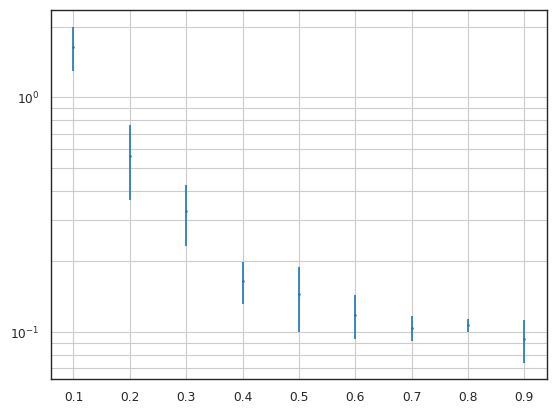

In [32]:
plt.scatter(perfs_with_unc.keys(), [x[0] for x in perfs_with_unc.values()], s=1)
plt.errorbar(perfs_with_unc.keys(), [x[0] for x in perfs_with_unc.values()], yerr=[x[1] for x in perfs_with_unc.values()], linestyle="None")
plt.yscale('log')
plt.grid(which='both')
plt.show()

In [33]:
def measure_parity_split(data, number, pairwise=False):
    if not isinstance(data, torch.Tensor):
        data = torch.tensor(data)
    if not isinstance(number, torch.Tensor):
        number = torch.tensor(number)
    def distance(a, b):
        # Define your distance function here
        return torch.norm(a - b).item()

    odd_position_distances = []
    consecutive_distances = []

    n_elements = len(number)

    if pairwise:
        even = data[number % 2 == 0]
        odd = data[number % 2 == 1]
        even_even = torch.triu(torch.cdist(even, even))
        even_even = even_even[even_even != 0]
        odd_odd = torch.triu(torch.cdist(odd, odd))
        odd_odd = odd_odd[odd_odd != 0]
        even_odd = torch.triu(torch.cdist(even, odd))
        even_odd = even_odd[even_odd != 0]
        return even_odd.mean() / (even_even.mean() + odd_odd.mean()) * 2

    for i in range(0, n_elements):
        if i+2 < n_elements:
            odd_position_distances.append(distance(data[i], data[i+2]))
        if i+1 < n_elements:
            consecutive_distances.append(distance(data[i], data[i+1]))

    avg_odd_position_distance = sum(odd_position_distances) / len(odd_position_distances)
    avg_consecutive_distance = sum(consecutive_distances) / len(consecutive_distances)

    return avg_consecutive_distance / avg_odd_position_distance

def measure_orderedness(data):
    assert data.shape[1] == 1
    # fraction of ordered elements (next > prev)
    return (data[1:] < data[:-1]).mean()

In [34]:
seed_of_choice = 1

In [35]:
all_paritys = {} 
for frac, location in all_trainfracs.items():
    paritys = defaultdict(list)
    args = IO.load_args(f"{location}/args.yaml")
    data = prepare_nuclear_data(args)
    mask = fix_val_mask_to_include_only_used_elements(data)
    which_nzs = data.X[mask].cpu()
    which_z = which_nzs[:,0].unique()
    which_n = which_nzs[:,1].unique()
    with torch.no_grad():
      for epoch, model_path in checkpoints.items():
        if epoch != last_epoch: continue
        # if frac[0] != seed_of_choice: continue
        model.load_state_dict(torch.load(f"{location}/ckpts/{model_path}", map_location="cpu"))
        z_emb = model.emb[0][which_z]
        n_emb = model.emb[1][which_n]
        # z_emb, n_emb = model.emb[0], model.emb[1]
        # z_emb, n_emb = z_emb[args.NUCLEI_GE + 1:140], n_emb[args.NUCLEI_GE + 1:140]
        
        # paritys[(0, 1)].append(measure_parity_split(z_emb.cpu().numpy(), which_z, pairwise=True))
        n_components = 1
        offset = 0
        pca = PCA(n_components=n_components + offset)
        emb_pca = pca.fit_transform(z_emb.detach().cpu().numpy())
        #paritys[(0, 1)].append(measure_parity_split(emb_pca, which_z, pairwise=True))
        paritys[(0, 1)].append(measure_orderedness(emb_pca))
        # for first in range(offset, n_components + offset):
        #   for second in range(first + 1, n_components + offset):
        #     parity = measure_parity_split(emb_pca[:, [first, second]], which_z, pairwise=True)
        #     paritys[(first, second)].append(parity)
            # plt.scatter(emb_pca[:, first], emb_pca[:, second], c=np.arange(len(emb_pca))%2, cmap="coolwarm")
            # plt.title(f"parity: {measure_parity_split(emb_pca[:, [first, second]])}, {first} vs {second}, perf {perfs[frac][last_epoch]:.0f}, frac {frac}")
            # for i, txt in enumerate(np.arange(len(emb_pca))):
            #   plt.annotate(txt, (emb_pca[i, first], emb_pca[i, second]))
            # plt.show()
    all_paritys[frac] = paritys

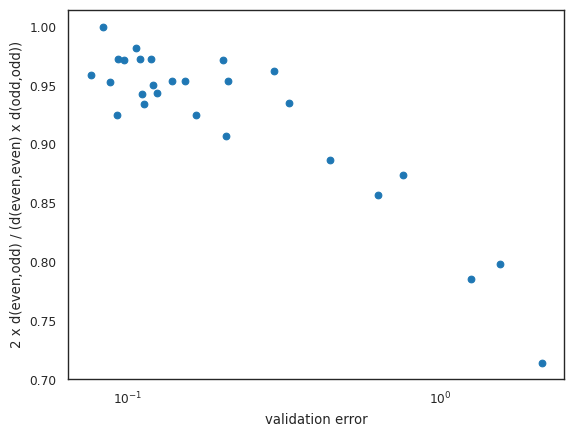

In [36]:
perfs_for_plot = []
paritys_for_plot = []
for seed in set([x[0] for x in all_paritys.keys()]):
  for frac in set([x[1] for x in all_paritys.keys()]):
    # if frac < .2: continue
    # if seed != seed_of_choice: continue
    perfs_for_plot.append(perfs[(seed, frac)][last_epoch])
    paritys_for_plot.append(min([x[-1] for x in all_paritys[(seed, frac)].values()]))
plt.scatter(perfs_for_plot, paritys_for_plot)
plt.ylabel("2 x d(even,odd) / (d(even,even) x d(odd,odd))")
plt.xlabel("validation error")
plt.xscale('log')
plt.show()

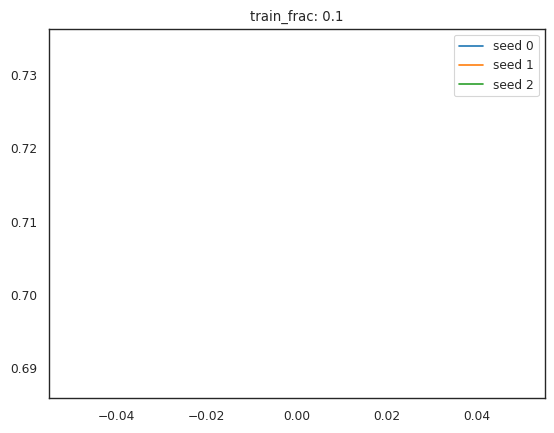

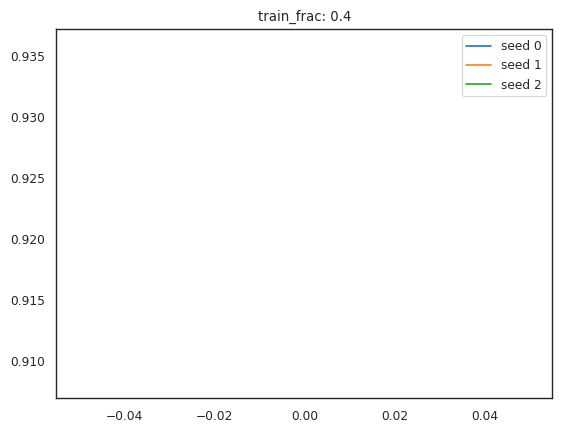

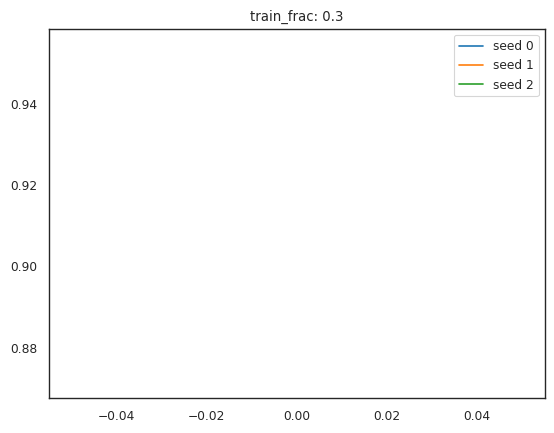

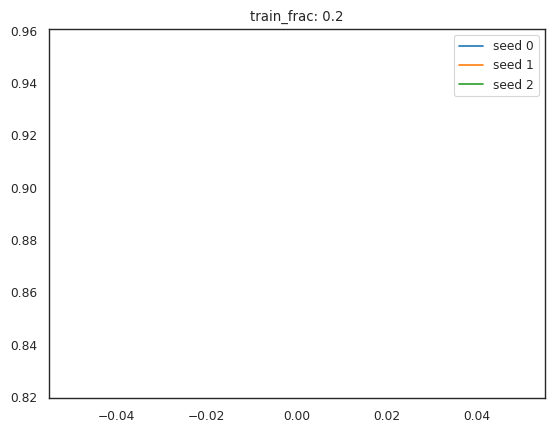

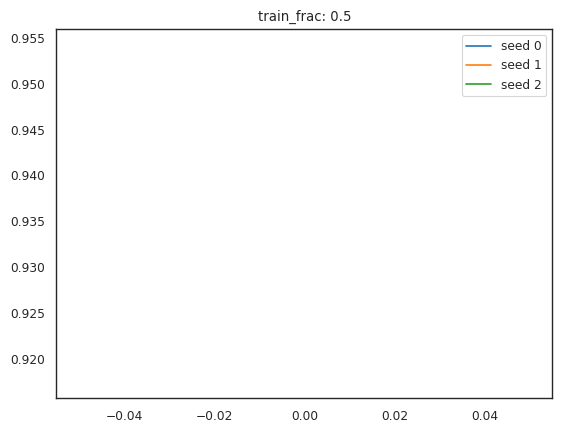

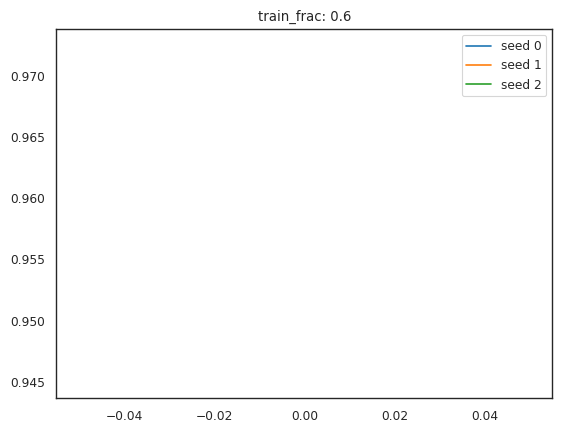

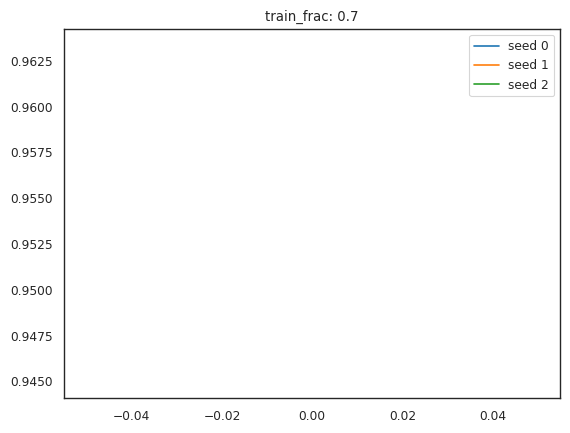

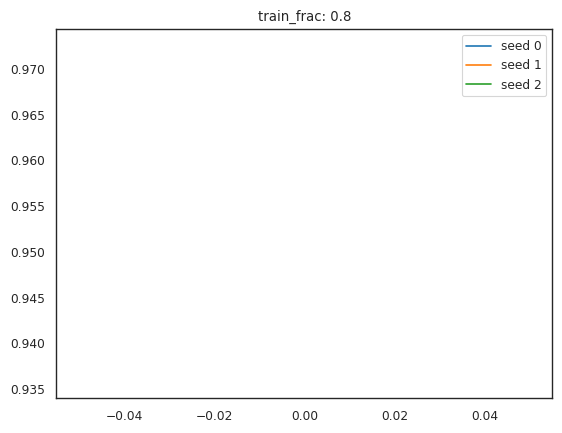

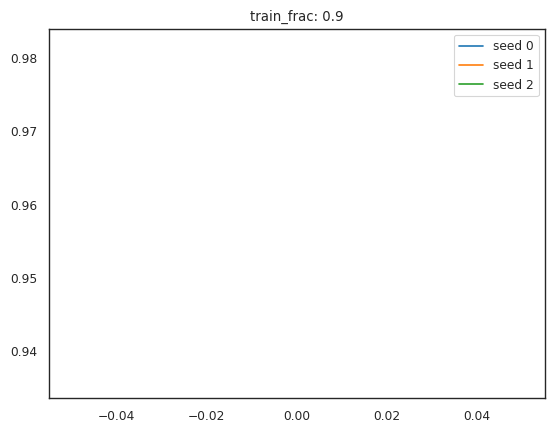

In [198]:
for train_frac in set([x[1] for x in all_paritys.keys()]):
  for seed in set([x[0] for x in all_paritys.keys()]):
    # if seed != seed_of_choice: continue
    # plotting the parity as a function train time for different train fracs
    values = all_paritys[(seed, train_frac)][(0,1)]
    plt.plot(values, label=f"seed {seed}")
  plt.title(f"train_frac: {train_frac}")
  plt.xlabel("train time (arbitrary units)")
  plt.ylabel("parity")
  plt.legend()
  plt.show()